In [1]:
import time

import numpy as np
import pandas as pd

from copy import deepcopy

from sklearn.metrics import accuracy_score

from scipy.special import expit

from matplotlib import pyplot as plt

In [2]:
def cross_entropy_loss(reference_Y, predicted_Y):
    
    loss = 0
    m = reference_Y.shape[0]
    
    for yt, yp in zip(reference_Y, predicted_Y):
        
        value = np.sum(yt * np.log(yp) + (1 - yt) * np.log(1 - yp))
        loss += value
    
    loss = -1 * (1 / m) * loss
    
    return loss


def one_hot_encoding(values):
    
    classes = np.unique(values).tolist()
    
    total_classes = len(classes)
    
    outputs = []
    
    for value in values:
        
        index = classes.index(value)
        
        output = np.zeros(total_classes)
        output[index] = 1
        
        outputs.append(output)
        
    outputs = np.array(outputs)
    
    return outputs

class NeuralNetwork:
    
    def __init__(self,
                 input_nodes,
                 first_hidden_nodes,
                 second_hidden_nodes,
                 output_nodes,
                 learning_rate,
                 hidden_activation_function,
                 hidden_activation_derivative):
        
        self.input_nodes = input_nodes
        self.first_hidden_nodes = first_hidden_nodes
        self.second_hidden_nodes = second_hidden_nodes
        self.output_nodes = output_nodes
        
        self.learning_rate = learning_rate
        
        self.bwih = np.random.uniform(-0.1, 0.1, self.first_hidden_nodes).reshape(self.first_hidden_nodes, 1)
        self.bwhh = np.random.uniform(-0.1, 0.1, self.second_hidden_nodes).reshape(self.second_hidden_nodes, 1)
        self.bwho = np.random.uniform(-0.1, 0.1, self.output_nodes).reshape(self.output_nodes, 1)
        
        self.wih = np.random.uniform(-0.1, 0.1, self.first_hidden_nodes * self.input_nodes).reshape(self.first_hidden_nodes, self.input_nodes)
        self.whh = np.random.uniform(-0.1, 0.1, self.second_hidden_nodes * self.first_hidden_nodes).reshape(self.second_hidden_nodes, self.first_hidden_nodes)
        
        hidden_nodes = self.first_hidden_nodes if (self.second_hidden_nodes == 0) else self.second_hidden_nodes
        
        self.who = np.random.uniform(-0.1, 0.1, self.output_nodes * hidden_nodes).reshape(self.output_nodes, hidden_nodes)
        
        self.hidden_activation_function = hidden_activation_function
        self.hidden_activation_derivative = hidden_activation_derivative
    
    def _softmax(self, x, eps = 1e-15):
        
        value = np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))
        
        return value
    
    def partial_fit(self, X, y):
        
        for inputs, targets in zip(X, y):

            self._train(inputs, targets)
    
    def _train(self, inputs, targets):
        
        if (self.second_hidden_nodes == 0):
            
            self._one_hidden_layer_train(inputs, targets)
            
        else:
            
            self._two_hidden_layer_train(inputs, targets)
        
    
    def _one_hidden_layer_train(self, inputs, targets):
        
        inputs = np.array(inputs, ndmin = 2).T
        targets = np.array(targets, ndmin = 2).T
                
        # Executes a Linear Combination
        hidden_inputs = np.dot(self.wih, inputs) + (self.bwih * 1)
        # Executes Activation Function
        hidden_outputs = self.hidden_activation_function(hidden_inputs)
        
        # Executes a Linear Combination
        final_inputs = np.dot(self.who, hidden_outputs) + (self.bwho * 1)
        # Executes Activation Function
        outputs = self._softmax(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - outputs
        
        self.bwho += self.learning_rate * output_errors
        
        # update the weights for the links between the hidden and output layers
        self.who += self.learning_rate * np.dot(output_errors, hidden_outputs.T)
                
        # first hidden layer error is the second_hidden_errors, split by weights, recombined at first hidden layer nodes
        hidden_errors = np.dot(self.who.T, output_errors)
        
        self.bwih += self.learning_rate * (hidden_errors * self.hidden_activation_derivative(hidden_inputs))
        
        # update the weights for the links between the first hidden layer and input layer
        self.wih += self.learning_rate * np.dot((hidden_errors * self.hidden_activation_derivative(hidden_inputs)), inputs.T)
        
    
    def _two_hidden_layer_train(self, inputs, targets):
        
        inputs = np.array(inputs, ndmin = 2).T
        targets = np.array(targets, ndmin = 2).T
        
        # Executes a Linear Combination
        first_hidden_inputs = np.dot(self.wih, inputs) + (self.bwih * 1)
        # Executes Activation Function
        first_hidden_outputs = self.hidden_activation_function(first_hidden_inputs)
        
        # Executes a Linear Combination
        second_hidden_inputs = np.dot(self.whh, first_hidden_outputs) + (self.bwhh * 1)
        # Executes Activation Function
        second_hidden_outputs = self.hidden_activation_function(second_hidden_inputs)
        
        # Executes a Linear Combination
        final_inputs = np.dot(self.who, second_hidden_outputs) + (self.bwho * 1)
        # Executes Activation Function
        outputs  = self._softmax(final_inputs)
        
        # output layer error is the (target - actual)
        output_errors = targets - outputs
        
        self.bwho += self.learning_rate * output_errors
        
        # update the weights for the links between the hidden and output layers
        self.who += self.learning_rate * np.dot(output_errors, second_hidden_outputs.T)
        
        # second hidden layer error is the output_errors, split by weights, recombined at second hidden layer nodes
        second_hidden_errors = np.dot(self.who.T, output_errors)
        
        self.bwhh += self.learning_rate * (second_hidden_errors * self.hidden_activation_derivative(second_hidden_inputs))
        
        # update the weights for the links between the first hidden layer and second hidden layer
        self.whh += self.learning_rate * np.dot((second_hidden_errors * self.hidden_activation_derivative(second_hidden_inputs)), first_hidden_outputs.T)
        
        # first hidden layer error is the second_hidden_errors, split by weights, recombined at first hidden layer nodes
        first_hidden_errors = np.dot(self.whh.T, second_hidden_errors)
        
        self.bwih += self.learning_rate * (first_hidden_errors * self.hidden_activation_derivative(first_hidden_inputs))
        
        # update the weights for the links between the first hidden layer and input layer
        self.wih += self.learning_rate * np.dot((first_hidden_errors * self.hidden_activation_derivative(first_hidden_inputs)), inputs.T)
    
    def predict(self, X):
        
        outputs = []
        
        for inputs in X:
            
            output = self._query(inputs)
            
            output = np.argmax(output)
            
            outputs.append(output)
            
        outputs = np.array(outputs)
        
        return outputs
    
    def predict_proba(self, X):
        
        outputs = []
        
        for inputs in X:
            
            output = self._query(inputs)
            
            outputs.append(output)
            
        outputs = np.array(outputs)
        
        return outputs
        
    
    def _query(self, inputs):
        
        result = np.array([])
        
        if (self.second_hidden_nodes == 0):
            
            result = self._one_hidden_layer_query(inputs)
        
        else:
            
            result = self._two_hidden_layer_query(inputs)
    
        return result
    
    def _one_hidden_layer_query(self, inputs):
        
        inputs = np.array(inputs, ndmin = 2).T
        
        # Executes a Linear Combination
        hidden_inputs = np.dot(self.wih, inputs) + (self.bwih * 1)
        # Executes Activation Function
        hidden_outputs = self.hidden_activation_function(hidden_inputs)
        
        # Executes a Linear Combination
        final_inputs = np.dot(self.who, hidden_outputs) + (self.bwho * 1)
        # Executes Activation Function
        final_outputs  = self._softmax(final_inputs)
        
        return final_outputs.ravel()
    
    def _two_hidden_layer_query(self, inputs):
        
        inputs = np.array(inputs, ndmin = 2).T
        
        # Executes a Linear Combination
        first_hidden_inputs = np.dot(self.wih, inputs) + (self.bwih * 1)
        # Executes Activation Function
        first_hidden_outputs = self.hidden_activation_function(first_hidden_inputs)
        
        # Executes a Linear Combination
        second_hidden_inputs = np.dot(self.whh, first_hidden_outputs) + (self.bwhh * 1)
        # Executes Activation Function
        second_hidden_outputs = self.hidden_activation_function(second_hidden_inputs)
        
        # Executes a Linear Combination
        final_inputs = np.dot(self.who, second_hidden_outputs) + (self.bwho * 1)
        # Executes Activation Function
        final_outputs  = self._softmax(final_inputs)
        
        return final_outputs.ravel()

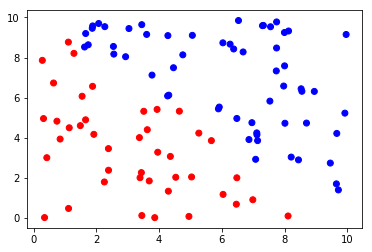

In [3]:
total_data = 200

X = np.random.uniform(0, 10, size = (100, 2))

y = [ int(((i + j) / 2) >= 5) for i, j in X ]

color = [ 'red' if i == 0 else 'blue' for i in y ]

plt.scatter(X[:, 0], X[:, 1], color = color)

plt.xticks()
plt.yticks()

plt.show()

In [4]:
training_size = 0.8

total = X.shape[0]

training_size = round(total * training_size)
validation_size = total - training_size

training_X = X[:training_size]
validation_X = X[training_size:]

training_y = y[:training_size]
validation_y = y[training_size:]

encoded_training_Y = one_hot_encoding(training_y)
encoded_validation_Y = one_hot_encoding(validation_y)

In [5]:
# Logística
#hidden_activation_function = lambda x : 1 / (1 + np.exp(-x))
#hidden_activation_derivative = lambda x : hidden_activation_function(x) * (1 - hidden_activation_function(x))

# ReLU
hidden_activation_function = lambda x : np.maximum(x, 0) 
hidden_activation_derivative = lambda x : 1 * (x > 0)

# Tangente Hiperbólica
#hidden_activation_function = lambda x : np.tanh(x)
#hidden_activation_derivative = lambda x : 1.0 - np.tanh(x) ** 2

In [6]:
epochs = 500

input_nodes = 2
first_hidden_nodes = 2
second_hidden_nodes = 0
output_nodes = 2
learning_rate = 0.01

n = NeuralNetwork(input_nodes,
                  first_hidden_nodes,
                  second_hidden_nodes,
                  output_nodes,
                  learning_rate,
                  hidden_activation_function,
                  hidden_activation_derivative)

total_start = time.time()

training_epochs = []
validation_epochs = []

for i in range(epochs):
    
    start = time.time()
    
    training_losses = []
    validation_losses = []
    
    n.partial_fit(training_X, encoded_training_Y)
    
    predicted_training_y = n.predict_proba(training_X)
    predicted_validation_y = n.predict_proba(validation_X)
    
    training_mean_loss = cross_entropy_loss(encoded_training_Y, predicted_training_y)
    validation_mean_loss = cross_entropy_loss(encoded_validation_Y, predicted_validation_y)
    
    training_epochs.append([i + 1, training_mean_loss])
    validation_epochs.append([i + 1, validation_mean_loss])
    
    finish = time.time()
    
    print("Epoch: " + str(i + 1) + " Training Loss: " + str(training_mean_loss) + " Validation Loss: " + str(validation_mean_loss) + " Time: " + str((finish - start)) + "s")
    
total_finish = time.time()

print("Elapsed Time: " + str((total_finish - total_start) / 60) + "mins")

Epoch: 1 Training Loss: 1.2615667611162922 Validation Loss: 1.3437733572182289 Time: 0.009021997451782227s
Epoch: 2 Training Loss: 1.164087686697736 Validation Loss: 1.2925673049642359 Time: 0.010026693344116211s
Epoch: 3 Training Loss: 1.1148849455962466 Validation Loss: 1.242662960209485 Time: 0.0070531368255615234s
Epoch: 4 Training Loss: 1.070608766541783 Validation Loss: 1.1954045467820298 Time: 0.008020639419555664s
Epoch: 5 Training Loss: 1.029109529145207 Validation Loss: 1.1515178926462528 Time: 0.008998632431030273s
Epoch: 6 Training Loss: 0.9901919310278379 Validation Loss: 1.1110512670727963 Time: 0.008044719696044922s
Epoch: 7 Training Loss: 0.9536697415297115 Validation Loss: 1.073468059775372 Time: 0.008995294570922852s
Epoch: 8 Training Loss: 0.9193696998245979 Validation Loss: 1.0385105871307914 Time: 0.007046937942504883s
Epoch: 9 Training Loss: 0.8871488609339843 Validation Loss: 1.0059499208645082 Time: 0.008029699325561523s
Epoch: 10 Training Loss: 0.85688997487612

Epoch: 100 Training Loss: 0.6648027474689522 Validation Loss: 0.7339501717797174 Time: 0.011028766632080078s
Epoch: 101 Training Loss: 0.4538915276450897 Validation Loss: 0.5188058322522274 Time: 0.009055137634277344s
Epoch: 102 Training Loss: 0.6169525054485442 Validation Loss: 0.7099975758937754 Time: 0.00799107551574707s
Epoch: 103 Training Loss: 0.6274543808883164 Validation Loss: 0.7361130119984035 Time: 0.009023904800415039s
Epoch: 104 Training Loss: 0.4477282349270252 Validation Loss: 0.5292256577898539 Time: 0.010026216506958008s
Epoch: 105 Training Loss: 0.2936441517062861 Validation Loss: 0.36043494741730747 Time: 0.009023427963256836s
Epoch: 106 Training Loss: 0.4705572814918229 Validation Loss: 0.5510874982653817 Time: 0.009285688400268555s
Epoch: 107 Training Loss: 0.4628394254339194 Validation Loss: 0.5446214004284956 Time: 0.0s
Epoch: 108 Training Loss: 0.7543092439596124 Validation Loss: 0.9810181394567681 Time: 0.0s
Epoch: 109 Training Loss: 1.1910537685603486 Validati

C:\ProgramData\Anaconda3\envs\unicamp\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\envs\unicamp\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


Epoch: 124 Training Loss: nan Validation Loss: nan Time: 0.01002645492553711s
Epoch: 125 Training Loss: nan Validation Loss: nan Time: 0.00902414321899414s
Epoch: 126 Training Loss: nan Validation Loss: nan Time: 0.011029958724975586s
Epoch: 127 Training Loss: nan Validation Loss: nan Time: 0.009023189544677734s
Epoch: 128 Training Loss: nan Validation Loss: nan Time: 0.008022308349609375s
Epoch: 129 Training Loss: nan Validation Loss: nan Time: 0.010025978088378906s
Epoch: 130 Training Loss: nan Validation Loss: nan Time: 0.009023666381835938s
Epoch: 131 Training Loss: nan Validation Loss: nan Time: 0.00902557373046875s
Epoch: 132 Training Loss: nan Validation Loss: nan Time: 0.011028528213500977s
Epoch: 133 Training Loss: nan Validation Loss: nan Time: 0.012031078338623047s
Epoch: 134 Training Loss: nan Validation Loss: nan Time: 0.00902414321899414s
Epoch: 135 Training Loss: nan Validation Loss: nan Time: 0.010026216506958008s
Epoch: 136 Training Loss: nan Validation Loss: nan Time:

Epoch: 250 Training Loss: nan Validation Loss: nan Time: 0.010025978088378906s
Epoch: 251 Training Loss: nan Validation Loss: nan Time: 0.009024620056152344s
Epoch: 252 Training Loss: nan Validation Loss: nan Time: 0.009055614471435547s
Epoch: 253 Training Loss: nan Validation Loss: nan Time: 0.008021354675292969s
Epoch: 254 Training Loss: nan Validation Loss: nan Time: 0.010008096694946289s
Epoch: 255 Training Loss: nan Validation Loss: nan Time: 0.01101541519165039s
Epoch: 256 Training Loss: nan Validation Loss: nan Time: 0.008021831512451172s
Epoch: 257 Training Loss: nan Validation Loss: nan Time: 0.008020877838134766s
Epoch: 258 Training Loss: nan Validation Loss: nan Time: 0.008021354675292969s
Epoch: 259 Training Loss: nan Validation Loss: nan Time: 0.008021831512451172s
Epoch: 260 Training Loss: nan Validation Loss: nan Time: 0.009023666381835938s
Epoch: 261 Training Loss: nan Validation Loss: nan Time: 0.005074739456176758s
Epoch: 262 Training Loss: nan Validation Loss: nan Ti

Epoch: 361 Training Loss: nan Validation Loss: nan Time: 0.015626907348632812s
Epoch: 362 Training Loss: nan Validation Loss: nan Time: 0.018048524856567383s
Epoch: 363 Training Loss: nan Validation Loss: nan Time: 0.010026693344116211s
Epoch: 364 Training Loss: nan Validation Loss: nan Time: 0.008052587509155273s
Epoch: 365 Training Loss: nan Validation Loss: nan Time: 0.008992910385131836s
Epoch: 366 Training Loss: nan Validation Loss: nan Time: 0.009023427963256836s
Epoch: 367 Training Loss: nan Validation Loss: nan Time: 0.004206180572509766s
Epoch: 368 Training Loss: nan Validation Loss: nan Time: 0.0s
Epoch: 369 Training Loss: nan Validation Loss: nan Time: 0.015626192092895508s
Epoch: 370 Training Loss: nan Validation Loss: nan Time: 0.0s
Epoch: 371 Training Loss: nan Validation Loss: nan Time: 0.01562643051147461s
Epoch: 372 Training Loss: nan Validation Loss: nan Time: 0.0s
Epoch: 373 Training Loss: nan Validation Loss: nan Time: 0.01562666893005371s
Epoch: 374 Training Loss: 

Epoch: 475 Training Loss: nan Validation Loss: nan Time: 0.01562666893005371s
Epoch: 476 Training Loss: nan Validation Loss: nan Time: 0.016429424285888672s
Epoch: 477 Training Loss: nan Validation Loss: nan Time: 0.011029243469238281s
Epoch: 478 Training Loss: nan Validation Loss: nan Time: 0.009024381637573242s
Epoch: 479 Training Loss: nan Validation Loss: nan Time: 0.006200075149536133s
Epoch: 480 Training Loss: nan Validation Loss: nan Time: 0.0s
Epoch: 481 Training Loss: nan Validation Loss: nan Time: 0.015626192092895508s
Epoch: 482 Training Loss: nan Validation Loss: nan Time: 0.0s
Epoch: 483 Training Loss: nan Validation Loss: nan Time: 0.015626907348632812s
Epoch: 484 Training Loss: nan Validation Loss: nan Time: 0.0s
Epoch: 485 Training Loss: nan Validation Loss: nan Time: 0.01562643051147461s
Epoch: 486 Training Loss: nan Validation Loss: nan Time: 0.015627145767211914s
Epoch: 487 Training Loss: nan Validation Loss: nan Time: 0.0s
Epoch: 488 Training Loss: nan Validation Lo

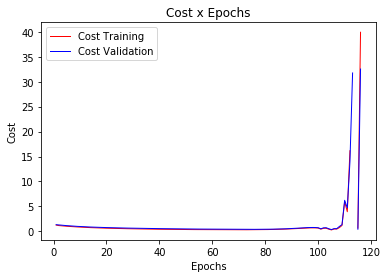

In [7]:
training_df = pd.DataFrame(data = training_epochs, columns = ['Epoch', 'Cost'])
validation_df = pd.DataFrame(data = validation_epochs, columns = ['Epoch', 'Cost'])

plt.plot(training_df['Epoch'], training_df['Cost'], linewidth = 1.0, color = 'red')
plt.plot(validation_df['Epoch'], validation_df['Cost'], linewidth = 1.0, color = 'blue')

plt.xlabel('Epochs')
plt.ylabel('Cost')

plt.title("Cost x Epochs")
plt.legend(['Cost Training', 'Cost Validation'])

plt.show()

In [8]:
y_predicted = n.predict(validation_X)
accuracy = accuracy_score(validation_y, y_predicted)
accuracy

0.5

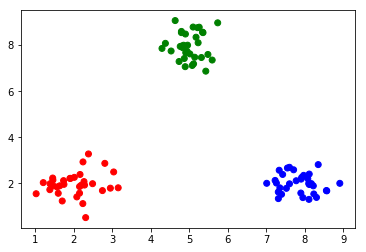

In [9]:
x1 = np.stack([np.random.normal(2, 0.5, 33), np.random.normal(2, 0.5, 33), [0] * 33], axis = 1)
x2 = np.stack([np.random.normal(5, 0.5, 33), np.random.normal(8, 0.5, 33), [1] * 33], axis = 1)
x3 = np.stack([np.random.normal(8, 0.5, 33), np.random.normal(2, 0.5, 33), [2] * 33], axis = 1)

data = np.concatenate((x1, x2, x3))

np.random.shuffle(data)

color = []

for x1, x2, y in data:
    
    if (y == 0):
        color.append('red')
    elif (y == 1):
        color.append('green')
    else:
        color.append('blue')

plt.scatter(data[:, 0], data[:, 1], color = color)

plt.xticks()
plt.yticks()

plt.show()

In [10]:
X = data[:, 0:2]
y = data[:, 2]

In [11]:
training_size = 0.8

total = X.shape[0]

training_size = round(total * training_size)
validation_size = total - training_size

training_X = X[:training_size]
validation_X = X[training_size:]

training_y = y[:training_size]
validation_y = y[training_size:]

encoded_training_Y = one_hot_encoding(training_y)
encoded_validation_Y = one_hot_encoding(validation_y)

In [12]:
# Logística
#hidden_activation_function = lambda x : 1 / (1 + np.exp(-x))
#hidden_activation_derivative = lambda x : hidden_activation_function(x) * (1 - hidden_activation_function(x))

# ReLU
hidden_activation_function = lambda x : np.maximum(x, 0) 
hidden_activation_derivative = lambda x : 1 * (x > 0)

# Tangente Hiperbólica
#hidden_activation_function = lambda x : np.tanh(x)
#hidden_activation_derivative = lambda x : 1.0 - np.tanh(x) ** 2

In [22]:
epochs = 200

input_nodes = 2
first_hidden_nodes = 3
second_hidden_nodes = 0
output_nodes = 3
learning_rate = 0.001

n = NeuralNetwork(input_nodes,
                  first_hidden_nodes,
                  second_hidden_nodes,
                  output_nodes,
                  learning_rate,
                  hidden_activation_function,
                  hidden_activation_derivative)

total_start = time.time()

training_epochs = []
validation_epochs = []

for i in range(epochs):
    
    start = time.time()
    
    training_losses = []
    validation_losses = []
    
    n.partial_fit(training_X, encoded_training_Y)
    
    predicted_training_y = n.predict_proba(training_X)
    predicted_validation_y = n.predict_proba(validation_X)
    
    training_mean_loss = cross_entropy_loss(encoded_training_Y, predicted_training_y)
    validation_mean_loss = cross_entropy_loss(encoded_validation_Y, predicted_validation_y)
    
    training_epochs.append([i + 1, training_mean_loss])
    validation_epochs.append([i + 1, validation_mean_loss])
    
    finish = time.time()
    
    print("Epoch: " + str(i + 1) + " Training Loss: " + str(training_mean_loss) + " Validation Loss: " + str(validation_mean_loss) + " Time: " + str((finish - start)) + "s")
    
total_finish = time.time()

print("Elapsed Time: " + str((total_finish - total_start) / 60) + "mins")

Epoch: 1 Training Loss: 1.902329811356405 Validation Loss: 1.9031576529669612 Time: 0.011058330535888672s
Epoch: 2 Training Loss: 1.8985313830353434 Validation Loss: 1.9023550194674095 Time: 0.008020639419555664s
Epoch: 3 Training Loss: 1.8944605129579226 Validation Loss: 1.900870537181297 Time: 0.009015321731567383s
Epoch: 4 Training Loss: 1.8899280901752162 Validation Loss: 1.8985320153506149 Time: 0.012038946151733398s
Epoch: 5 Training Loss: 1.8847287263182764 Validation Loss: 1.8954428466255733 Time: 0.01002645492553711s
Epoch: 6 Training Loss: 1.878620076537949 Validation Loss: 1.8911416626745243 Time: 0.008020401000976562s
Epoch: 7 Training Loss: 1.871314258968085 Validation Loss: 1.8853557257588045 Time: 0.008021831512451172s
Epoch: 8 Training Loss: 1.8624901338655167 Validation Loss: 1.8777776251712155 Time: 0.0069849491119384766s
Epoch: 9 Training Loss: 1.8517109992763408 Validation Loss: 1.868545492592977 Time: 0.008021354675292969s
Epoch: 10 Training Loss: 1.838561048427365

Epoch: 87 Training Loss: 0.5103855360255123 Validation Loss: 0.2868750223614102 Time: 0.015999555587768555s
Epoch: 88 Training Loss: 0.5055936557281898 Validation Loss: 0.28359432301906135 Time: 0.010027170181274414s
Epoch: 89 Training Loss: 0.5008706740211292 Validation Loss: 0.28036604209705646 Time: 0.009023904800415039s
Epoch: 90 Training Loss: 0.4962153338817421 Validation Loss: 0.2771888215841703 Time: 0.01002645492553711s
Epoch: 91 Training Loss: 0.4916264126487494 Validation Loss: 0.27406143707554204 Time: 0.01002645492553711s
Epoch: 92 Training Loss: 0.48710272170104874 Validation Loss: 0.27098276500667995 Time: 0.009023904800415039s
Epoch: 93 Training Loss: 0.48264310576426706 Validation Loss: 0.2679517597438012 Time: 0.009894847869873047s
Epoch: 94 Training Loss: 0.47824644193761645 Validation Loss: 0.2649674374625119 Time: 0.010025262832641602s
Epoch: 95 Training Loss: 0.4739116385316008 Validation Loss: 0.26202886470654485 Time: 0.009023427963256836s
Epoch: 96 Training Los

Epoch: 170 Training Loss: 0.26973477274120655 Validation Loss: 0.1307776838294826 Time: 0.010089874267578125s
Epoch: 171 Training Loss: 0.2680912716591779 Validation Loss: 0.12978034603278063 Time: 0.009022235870361328s
Epoch: 172 Training Loss: 0.26646611532246234 Validation Loss: 0.1287944929762295 Time: 0.008021354675292969s
Epoch: 173 Training Loss: 0.26485901803881445 Validation Loss: 0.1278201978059963 Time: 0.011028766632080078s
Epoch: 174 Training Loss: 0.2632697045632128 Validation Loss: 0.12685746207322363 Time: 0.00902414321899414s
Epoch: 175 Training Loss: 0.2616979079290304 Validation Loss: 0.1259062379228234 Time: 0.009023904800415039s
Epoch: 176 Training Loss: 0.2601433680365056 Validation Loss: 0.124966443472326 Time: 0.00902414321899414s
Epoch: 177 Training Loss: 0.258605830712713 Validation Loss: 0.12403797349228561 Time: 0.0030815601348876953s
Epoch: 178 Training Loss: 0.2570850470717557 Validation Loss: 0.12312070684385773 Time: 0.0s
Epoch: 179 Training Loss: 0.2555

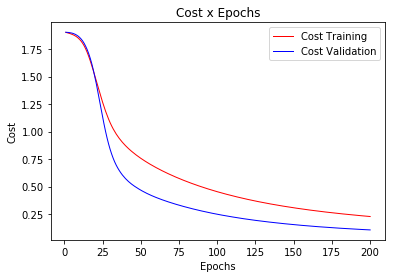

In [23]:
training_df = pd.DataFrame(data = training_epochs, columns = ['Epoch', 'Cost'])
validation_df = pd.DataFrame(data = validation_epochs, columns = ['Epoch', 'Cost'])

plt.plot(training_df['Epoch'], training_df['Cost'], linewidth = 1.0, color = 'red')
plt.plot(validation_df['Epoch'], validation_df['Cost'], linewidth = 1.0, color = 'blue')

plt.xlabel('Epochs')
plt.ylabel('Cost')

plt.title("Cost x Epochs")
plt.legend(['Cost Training', 'Cost Validation'])

plt.show()

In [15]:
y_predicted = n.predict(validation_X)
accuracy = accuracy_score(validation_y, y_predicted)
accuracy

1.0